## Project Workflow

In [1]:
# Create only training & testing datasets
# 1. Design Directories for Images (Before & After Preprocessing)
# 2. Create Preprocessing Pipeline for Train & Test Data (Using Sklearn)
# 3. Using Localization For Enhancing the images
# 4. Workflow: Resizing , Noise Removing, Localization , Try Edge Detection (To identify tumors).
# 5. Use ImageDataGenerator for easier augmentation (Reason for creating directories)
# 6. Feature Extraction Techniques
# 6. Create a DCNN Model 
# 7. Create a Streamlit Application using Streamlit, HTML,CSS,JavaScript

<b><u>Links for Refrence:</u></b>
1. https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
2. https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
3. https://www.kaggle.com/code/ethernext/brain-tumour-detection-with-cnn-96-accuracy
4. https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2#:~:text=Exploratory%20data%20analysis%20comprises%20of,of%20predictors%20across%20different%20classes.
5. https://pyvideo.org/pydata-chicago-2016/using-exploratory-data-analysis-to-discover-patterns-in-image-and-document-collections.html
6. https://algoritmaonline.com/image-classification-cnn/

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np 
import cv2
import os
import seaborn as sn 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm
import random
import tensorflow as tf
import sklearn
import time
import sys
%matplotlib inline

### Loading Data

The Machine Learning lifecycle begins with identifying and fetching relevant data required for creating our model. In our case the required data, digital images, are stored in a directory in the enviornment under the label 'brain-tumor-dataset'. The directory is sub-divided into "yes" and "no" files, each storing images belonging to their respective class labels.

In [7]:
# Walk through brain-tumor-dataset directory and list number of files
for dirpath, dirnames, filenames in os.walk("brain_tumor_dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'brain_tumor_dataset'.
There are 0 directories and 98 images in 'brain_tumor_dataset\no'.
There are 0 directories and 155 images in 'brain_tumor_dataset\yes'.


In [14]:
number_images_yes = len(os.listdir("brain_tumor_dataset\\yes"))
number_images_no = len(os.listdir("brain_tumor_dataset\\no"))
print(f"Number of Brain MRI Images not having tumor :{number_images_no} ")
print(f"Number of Brain MRI Images having tumor : {number_images_yes}")

Number of Brain MRI Images not having tumor :98 
Number of Brain MRI Images having tumor : 155


Now that we have a brief idea about how the images are stored, let's start by creating a python function to import the images into our jupyter notebook. 

In [17]:
def load_data():
    """ Helper function to load data"""
    
    # Creating file paths for the folders storing the images for each class label
    file_path = r"C:\Users\Sidhant Mathur\Desktop\Projects\Brain_Tumor_Detection\brain_tumor_dataset"
    yes_directory = ""
    no_directory = ""
    
    for classes in os.listdir(file_path):
        if classes.startswith("y"):
            yes_directory = file_path + "\\yes"
        else:
            no_directory = file_path + "\\no"
            
               
    # Creating 2 lists, "yes_images" and "no_images" to store the filepaths of the images. These filepaths will be used 
    # to create the training, testing and validation set
    no_images = [file_path+"\\no\\"+str(os.listdir(no_directory)[i]) for i in range(0,len(os.listdir(no_directory)))]
    yes_images = [file_path+"\\yes\\"+str(os.listdir(yes_directory)[i]) for i in range(0,len(os.listdir(yes_directory)))]
    
    # Creating a list of labels for each suitable class label : "Tumor" or "No Tumor"
    no_label = ["No Tumor"] * len(no_images)
    yes_label = ["Tumor"] * len(yes_images)    
    
    # Merging the 2 class labels to create the final dataset
    all_images = no_images+yes_images
    all_labels = no_label+yes_label
    
    # Shuffling the elements of the dataset
    data_tuple = tuple(zip(all_images,all_labels))
    shuffled_tuple = tuple(random.sample(data_tuple, len(data_tuple)))
    shuffled_images = []
    shuffled_labels = []
    for i in range(0,len(shuffled_tuple)):
        shuffled_images.append(shuffled_tuple[i][0])
        shuffled_labels.append(shuffled_tuple[i][1])
    
    return shuffled_images,shuffled_labels

In [18]:
# Importing the images & labels
images, labels = load_data()

Now that we have imported our images, we can progress towards creating 3 seperate datasets namely; `training, validation and testing` sets. The `training set` is going to be utilize to `create` the machine learning model. The `validation set` is used to compare various trained models and `determine the best set of hyperparameters` for the model. The `testing set` acts like unseen data; this set is used for `evaluating the performance` of our model. Let's go on and create a function to split our data.

In [21]:
def create_datasets(list_of_images,list_of_labels,train_ratio,valid_ratio,test_ratio):
    """ Helper function to create training, validation and testing stage"""
    
    # Creating the indices for to demarcation of training, validation and testing set
    train_idx = int(train_ratio*len(list_of_images))
    valid_idx = int(valid_ratio*len(list_of_images))
    test_idx = int(test_ratio*len(list_of_images))
    
    train_images, train_labels = list_of_images[:train_idx] , list_of_labels[:train_idx]
    valid_images,valid_labels = list_of_images[train_idx+1: train_idx+1+valid_idx] , list_of_labels[train_idx+1: train_idx+1+valid_idx]
    test_images,test_labels = list_of_images[train_idx+1+valid_idx+1 : train_idx+1+valid_idx+1+test_idx ] , list_of_labels[train_idx+1+valid_idx+1 : train_idx+1+valid_idx+1+test_idx ]
    
    return train_images,train_labels,valid_images,valid_labels,test_images,test_labels

In [22]:
# Creating datasets
train_images,train_labels,valid_images,valid_labels,test_images,test_labels = create_datasets(images,labels,0.75,0.15,0.10)

### Exploratory Data Analysis


<b>*Finally!*</b> We have imported and split our data into various datasets. We now have everything we need to start familiarizing ourselves with the images, gather some insights about the nature of our images & find any information which can give us an idea as to what kind of preprocessing the images will have to undergo.

Visualizing is amongst the most popular and effective approach, when dealing with images. Let's write a function to randomly sample some images from the training set and visualize them.

In [23]:
def visualize_images():
    """ Helper function to visualize images randomly"""
    
    # Selecting 15 random images from the training,validation and testing set
    train_samples = random.sample(train_images, 5)
    train_class = [train_labels[train_images.index(train_samples[i])] for i in range(0,5)]
    
    valid_samples = random.sample(valid_images, 5)
    valid_class = [valid_labels[valid_images.index(valid_samples[i])] for i in range(0,5)]
    
    test_samples = random.sample(test_images, 5)
    test_class = [test_labels[test_images.index(test_samples[i])] for i in range(0,5)]
    
    fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,4));
    fig.suptitle("Training Set Images (Sampled Without Replacement)",fontsize=16)
    for i in range(0,5):
        ax[i].imshow(mpimg.imread(train_samples[i])); 
        ax[i].set_title(str(train_class[i]),fontsize = 14)
    fig.tight_layout()
        
    fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,4));
    fig.suptitle("Validation Set Images (Sampled Without Replacement)",fontsize=16)
    for i in range(0,5):
        ax[i].imshow(mpimg.imread(valid_samples[i])); 
        ax[i].set_title(str(valid_class[i]),fontsize=14)
    fig.tight_layout()
    
    fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,4));
    fig.suptitle("Testing Set Images (Sampled Without Replacement)",fontsize=16)
    for i in range(0,5):
        ax[i].imshow(mpimg.imread(test_samples[i])); 
        ax[i].set_title(str(test_class[i]),fontsize=14)
    fig.tight_layout()

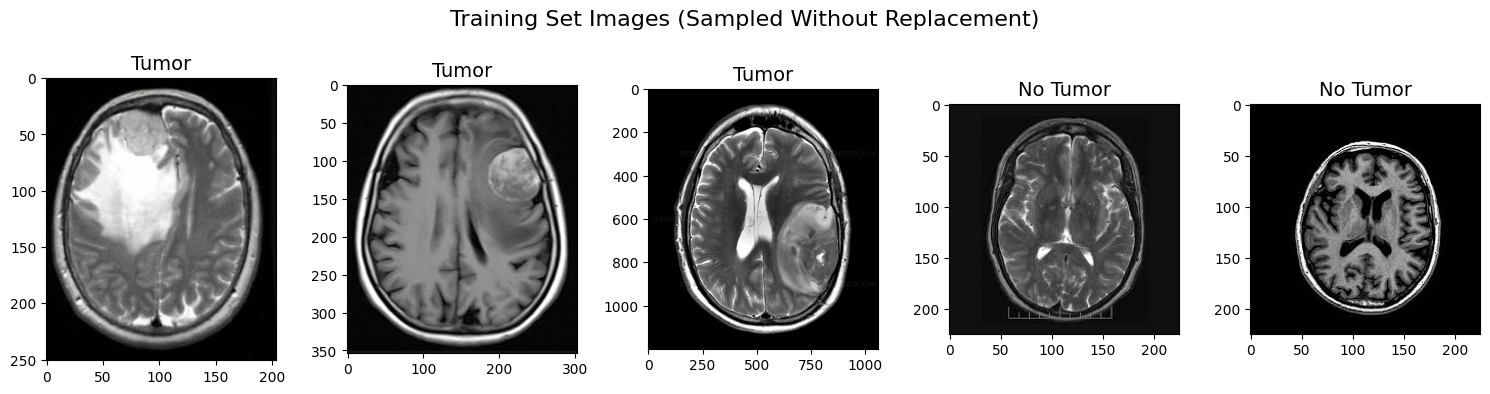

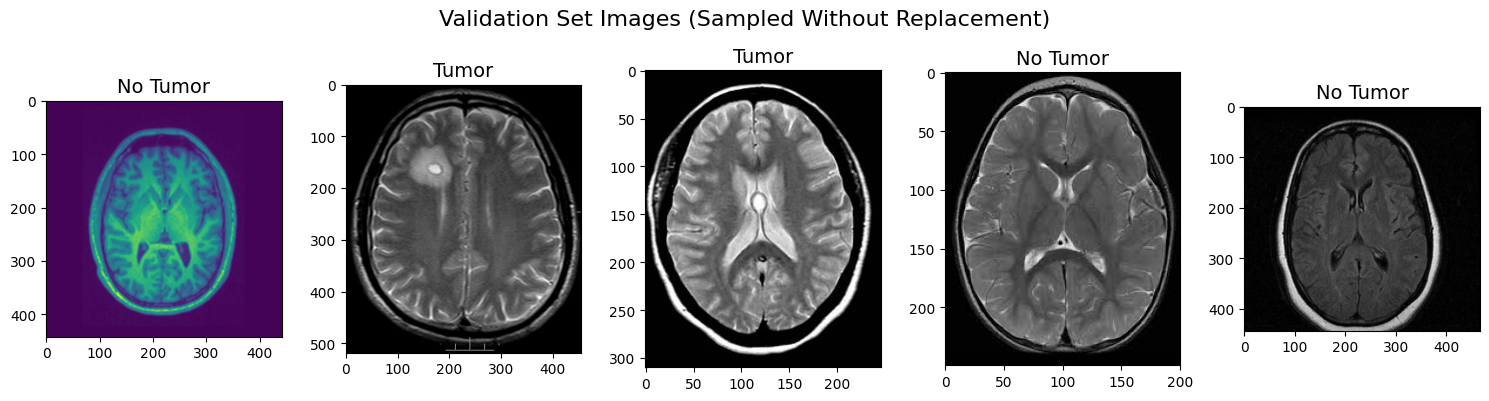

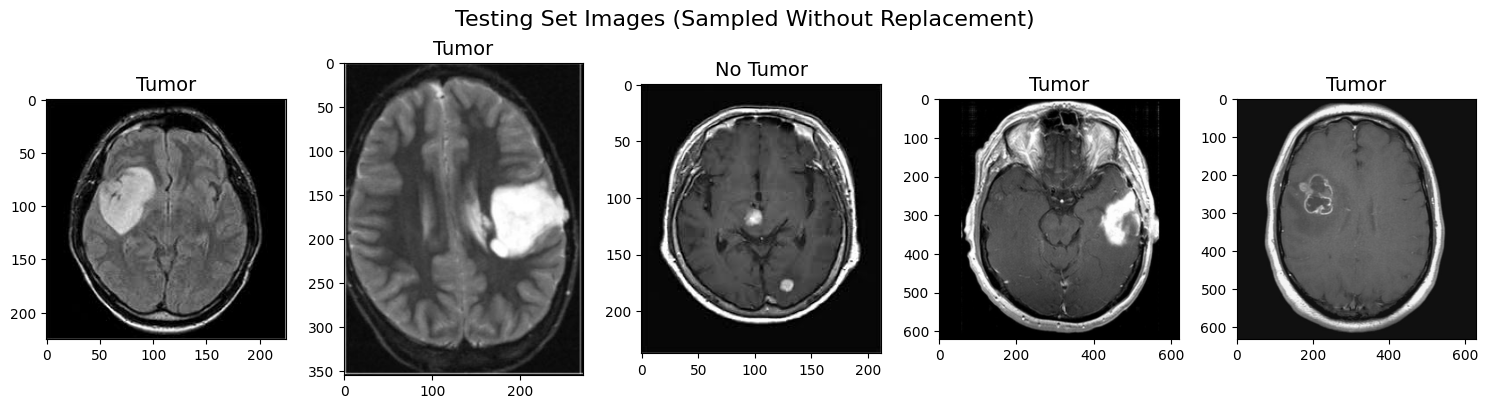

In [24]:
# Visualizing Images
visualize_images()

In [26]:
# Average Image
# Contrast Between Average Images
# Eigenimages
# Distribution of pixel intensities by class (summary statistics)
# Image Splitting (Color Distribution of images)
# Image Scatterplots & Histograms 
# Greyscale Image Intensity Distribution 

https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/image-scatter-plot.htm

https://algoritmaonline.com/image-classification-cnn/